# Exercise 5 - Optimal interpolation


**Aim:** To map temperature data.

**Data:**  

**Directions:** Create an `*.ipynb` and 

<hr>

## Create a notebook 

1. Create an `*.ipynb` containing the commands for this assignment, or copy this file.  
    
    ```{admonition} File naming convention
    Name your python notebook something useful `ex<X>-<Lastname>-<slug>-seaocn.ipynb` where you replace `<X>` with the exercise number and `<slug>` with the short slug to name the topic, and `<Lastname>` with your last name.

    Figures should be named something like `ex<X>fig<Y>-<Lastname>-<slug>-seaocn.png` where you replace `<X>` with the exercise number, `<Y>` with the figure number, and `<Lastname>` with your last name.
    ```

2. Import necessary packages.  



    For example, `matplotlib` and `pandas` and `numpy` and `xarray`.  You may also need `scipy`.
    ```
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import xarray as xr
    from datetime import datetime
    ```
    If you are missing any of these packages, please refer to [Resources: Python](../resource/python).



In [1]:
# Your code here
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import datetime
import scipy.io as sio
from matplotlib.patches import Rectangle

# Some extra colormaps
import cmocean

# Fancy but non-intuitive
import pygmt



### Load Matlab data

3. Use the file `argo_med.mat` in the `data/` directory.  With the `scipy` package, you can load matlab-format data files into python.

    ```{seealso}
    Scipy io: [https://docs.scipy.org/doc/scipy/tutorial/io.html](https://docs.scipy.org/doc/scipy/tutorial/io.html)
    ```

4. Load the file.  Here, we're loading the matlab file into something called `mat_contents`.  Make a basic exploration. How big are the data?  What are the coordinates?

    ```
    mat_contents = sio.loadmat(fname)
    print(mat_contents.keys())
    print(mat_contents['time'])
    ```
    Since the functions you have available depend on the type of the variable, don't forget to use `type()` to find out what's in there.


In [2]:
# Your code here
file_path = '../data/'
filename = 'argo_med.mat'
fname = file_path + filename
mat_contents = sio.loadmat(fname)

#print(mat_contents.keys())
time = mat_contents['time']
pres0 = mat_contents['pres0']
latd = mat_contents['latd']
lond = mat_contents['lond']
tprof = mat_contents['tprof']

# https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python
datenums = time.flatten()
timestamps = pd.to_datetime(datenums-719529, unit='D')
#    time1 = np.datetime64('2003-0' + str(mm+1) + '-15')


#def datetime2matlabdn(dt):
#    mdn = dt + datetime.timedelta(days = 366)
#    tstr = dt.strftime("%d-%b-%Y")
#    dt_day = np.datetime64(tstr)
#    
#   frac_seconds = (dt-datetime.datetime(dt.year.values,dt.month.values,dt.day.values,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
#   frac_microseconds = dt.microsecond / (24.0 * 60.0 * 60.0 * 1000000.0)
#   return mdn.toordinal() + frac_seconds + frac_microseconds

#time2 = datetime2matlabdn(timestamps)
#print(time2[0,3])

In [3]:
dt = timestamps
tstr = dt.strftime("%d-%b-%Y")
tstr[0]

'18-Jan-2003'

### Convert data to `xarray`

We like `xarray` in this course, so rather than handling these

In [4]:
#data_xr = xr.DataArray(data = tprof,
#                       coords={'time': time, 'pres': pres0},
#                       dims = ["time", "pres"])

### Error: `MissingDimensionsError`

If you get an error like `MissingDimensionsError: cannot set variable 'pres' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.`, this is a problem with the `shape` or size of your pressure or time dimensions.  Xarray wants these to be 1-dimensional.

Try a `np.shape(time)` to see how big it is.

If it is 1-dimensional, it will return something like
```(1019,)```

If it is returning ```(1, 1019)```, this is 2-dimensional, and xarray is having trouble with it.

```{seealso}
We dealt with problems of dimensionality in [Ex-tseries](exercise-tseries.ipynb).  The solution there was a little magical function called `squeeze()` available in `xarray`.  Our variable here is a `numpy` array, but there also exists the function `numpy.squeeze()`.
```


In [5]:
# Your code here.  
# Note that several of the below commands produce output, but youll only see the latest output print to the screen.
# If you want to see the output of the others, encase it with `print(...)`
type(tprof)
np.shape(tprof)
type(latd)
np.shape(time)
time = time.squeeze()
np.shape(time)
pres0 = pres0.squeeze()
np.shape(pres0)
latd = latd.squeeze()
lond = lond.squeeze()

data_xr = xr.DataArray(name = 'tprof', data = tprof,
                       coords={'time': time, 'pres': pres0},
                       dims = ["time", "pres"])
data_xr2 = xr.DataArray(name = 'latd', data = latd,
                        coords = {'time': time},
                        dims = ["time"])
data_xr3 = xr.DataArray(name = 'lond', data = lond,
                        coords = {'time': time},
                        dims = ["time"])
data_xr4 = xr.DataArray(name = 'timestamps', data = timestamps,
                        coords = {'time': time},
                        dims = ["time"])

argo_med = xr.merge([data_xr,data_xr2,data_xr3,data_xr4])

#argo_med = xr.combine_by_coords([data_xr, data_xr2,data_xr3])

print(argo_med)

<xarray.Dataset>
Dimensions:     (time: 1019, pres: 6)
Coordinates:
  * time        (time) float64 7.316e+05 7.316e+05 ... 7.317e+05 7.317e+05
  * pres        (pres) uint8 10 20 30 40 50 60
Data variables:
    tprof       (time, pres) float64 20.98 20.98 20.98 ... 9.966 9.793 9.707
    latd        (time) float64 30.29 30.8 30.39 31.33 ... 59.88 59.63 59.8 59.68
    lond        (time) float64 332.2 337.0 337.3 337.3 ... 325.5 326.3 339.4
    timestamps  (time) datetime64[ns] 2003-01-18T05:19:40.800005760 ... 2003-...


### Fig. 1 Plot data locations

This is a quick-and-dirty plot, so `matplotlib` is fine.

Text(0.5, 1.0, 'Argo profile locations')

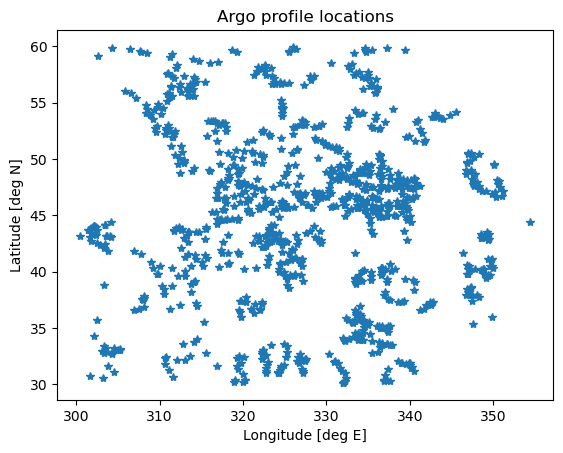

In [6]:
# Your code here
plt.plot(argo_med.lond, argo_med.latd,'*')
plt.xlabel('Longitude [deg E]')
plt.ylabel('Latitude [deg N]')
plt.title('Argo profile locations')

### Select a map region & pressure surface

```
minlat = 40
maxlat = 50
minlon = 320
maxlon = 340
```

- Draw a box on top of your figure to show where the selected region is.

- Save the figure as Fig 1 for this exercise.  `ex5fig1-<LastName>-data_locations-seaocn.png`

We'll work with data in an area with particularly high density of float profiles.

Choose a pressure surface to work with. Note that your pressure vector is 6 elements long.  Pick one depth to work with.

<xarray.DataArray 'tprof' (time: 1019)>
array([20.98333295, 19.66957312, 20.17708576, ...,  7.73461412,
        8.22999978, 11.18670421])
Coordinates:
  * time     (time) float64 7.316e+05 7.316e+05 ... 7.317e+05 7.317e+05
    pres     uint8 10


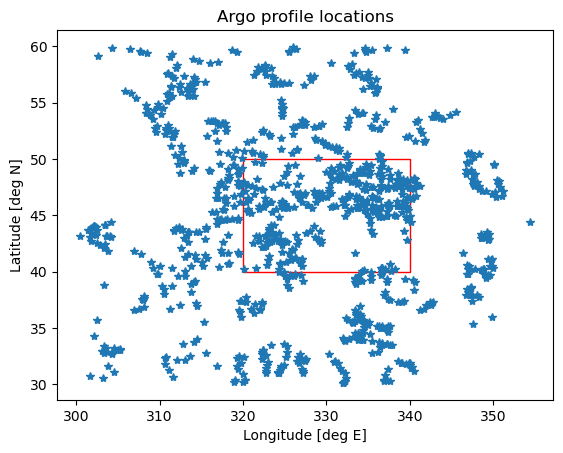

In [7]:
minlat = 40
maxlat = 50
minlon = 320
maxlon = 340

# Your code here
fig, ax = plt.subplots()

plt.plot(argo_med.lond, argo_med.latd,'*')
plt.xlabel('Longitude [deg E]')
plt.ylabel('Latitude [deg N]')
plt.title('Argo profile locations')
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

fig.savefig("figures/ex5fig1-Example-data_locations-seaocn.png")

# Figure out how big the datasets are
temp = argo_med['tprof'][:,0]
print(temp)

### Fig 2. Clip to a region and plot

You've defined a maximum and minimum longitude and latitude above, and now you'd like to make your dataset smaller to work only within this region.

`xarray` has a few options for finding/selecting/choosing subsets of a dataset.  These include `xr.sel()`, `xr.where()`, `xr.loc()`, etc.  They have some similarities and differences which we won't go into here.

```{seealso}
If you do a google search for `subset xarray by lat lon region`, one of the options that shows up (as of 17 April 2024) is:
https://gis.stackexchange.com/questions/353698/how-to-clip-an-xarray-to-a-smaller-extent-given-the-lat-lon-coordinates

There are a few solutions offered by the community.  Try them and see which works.
```

<xarray.Dataset>
Dimensions:     (time: 306, pres: 6)
Coordinates:
  * time        (time) float64 7.316e+05 7.316e+05 ... 7.317e+05 7.318e+05
  * pres        (pres) uint8 10 20 30 40 50 60
Data variables:
    tprof       (time, pres) float64 15.19 15.19 15.19 15.19 ... 13.4 13.4 13.4
    latd        (time) float64 40.3 41.32 41.22 42.56 ... 49.54 49.49 49.86
    lond        (time) float64 336.5 325.7 326.4 321.2 ... 334.8 335.4 336.6
    timestamps  (time) datetime64[ns] 2003-01-29T01:04:48.000003584 ... 2003-...


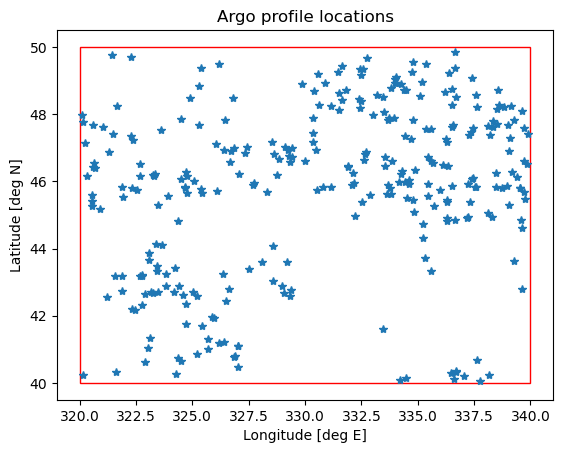

In [8]:
# This fails because our latitude and longitude vectors are 'variables' and time is the only coordinate
#cropped_ds = argo_med.sel(latd=slice(minlat,maxlat), lond=slice(minlon,maxlon))

mask_lon = (argo_med.lond >= minlon) & (argo_med.lond <= maxlon)
mask_lat = (argo_med.latd >= minlat) & (argo_med.latd <= maxlat)

argo_reg = argo_med.where(mask_lon & mask_lat, drop=True)

print(argo_reg)

# Your code here
fig, ax = plt.subplots()

plt.plot(argo_reg.lond,argo_reg.latd,'*')
plt.xlabel('Longitude [deg E]')
plt.ylabel('Latitude [deg N]')
plt.title('Argo profile locations')
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

fig.savefig("figures/ex5fig2-Example-data_locations-seaocn.png")

## Remove mean & any obvious latitudinal dependence

```
plt.hist(argo_reg.tprof.values.flatten())
```

(array([  6.,   0.,  18.,  16., 267., 669., 471., 253.,  78.,  38.]),
 array([ 4.67600012,  6.12231186,  7.5686236 ,  9.01493534, 10.46124707,
        11.90755881, 13.35387055, 14.80018229, 16.24649403, 17.69280577,
        19.13911751]),
 <BarContainer object of 10 artists>)

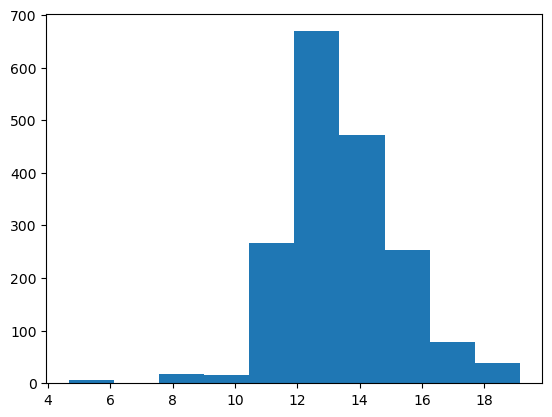

In [9]:
plt.hist(argo_reg.tprof.values.flatten())

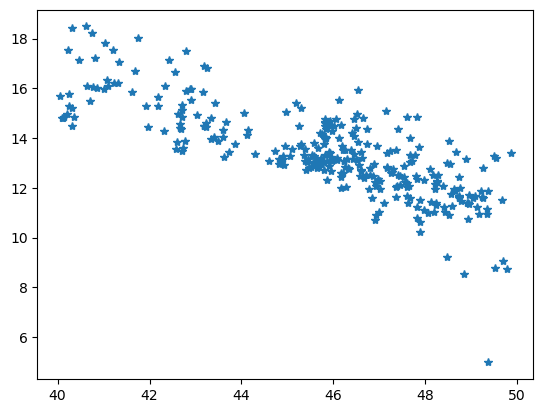

In [10]:
# Determine latitude dependence
plt.plot(argo_reg.latd,argo_reg.tprof[:,3],'*')

### Fit a line

Recall from [exercise 2a tseries](exercise-tseries.ipynb) how to fit a 1-degree polynomial.


In [11]:
# Fit a line
#line1 = argo_reg.tprof[:,3].polyfit(dim=latd,deg=1)
lat1 = argo_reg.latd.values
temp1 = argo_reg.tprof[:,3].values

temp_anom = temp1
ikeep = ~np.isnan(temp1)

lat1 = lat1[ikeep]
temp1 = temp1[ikeep]


pf = np.polyfit(lat1, temp1, 1);
xp = np.linspace(40,50, 20)
p1 = np.poly1d(np.polyfit(lat1, temp1, 1))

# Calculate anomalies relative to the latitudinal gradient

lat_model = p1(lat1)
temp_anom[ikeep] = temp1-lat_model


# Merge these back into the original
data_xr4 = xr.DataArray(name = 'temp_anom', data = temp_anom,
                        coords = {'time': argo_reg.time},
                        dims = ["time"])

argo_reg = xr.merge([argo_reg,data_xr4])
print(argo_reg) 

<xarray.Dataset>
Dimensions:     (time: 306, pres: 6)
Coordinates:
  * time        (time) float64 7.316e+05 7.316e+05 ... 7.317e+05 7.318e+05
  * pres        (pres) uint8 10 20 30 40 50 60
Data variables:
    tprof       (time, pres) float64 15.19 15.19 15.19 -1.295 ... 2.29 13.4 13.4
    latd        (time) float64 40.3 41.32 41.22 42.56 ... 49.54 49.49 49.86
    lond        (time) float64 336.5 325.7 326.4 321.2 ... 334.8 335.4 336.6
    timestamps  (time) datetime64[ns] 2003-01-29T01:04:48.000003584 ... 2003-...
    temp_anom   (time) float64 -1.295 0.2814 0.2603 1.461 ... 1.909 1.968 2.29


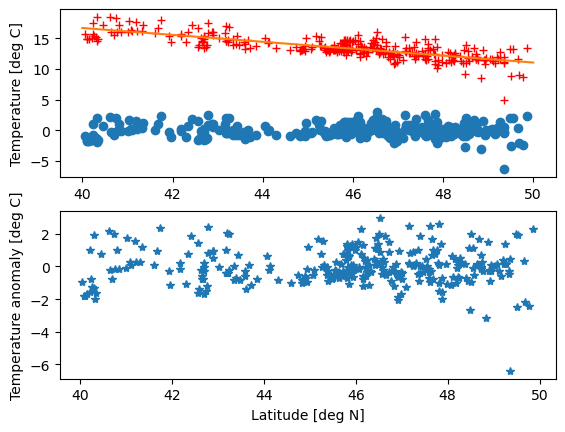

In [12]:
# Your code here
fig, ax = plt.subplots(2,1)

# Determine latitude dependence
ax[0].plot(argo_reg.latd,argo_reg.tprof[:,3],'o')


ax[0].plot(lat1,temp1,'r+')



ax[0].plot(xp,p1(xp))

ax[1].plot(lat1, temp_anom[ikeep],'*')
ax[1].set_xlabel('Latitude [deg N]')
ax[1].set_ylabel('Temperature anomaly [deg C]')
ax[0].set_ylabel('Temperature [deg C]')

fig.savefig("figures/ex5fig2-Example-data_locations-seaocn.png")

## Remove outliers larger than 3 standard deviations



In [13]:
# Remove the outliers
std1 = np.nanstd(temp_anom)
print(std1)

mask_outlier = (argo_reg.temp_anom > -3*std1) | (argo_reg.temp_anom > 3*std1) 
argo_reg_good = argo_reg.where(mask_outlier, drop=True)

mp = argo_reg_good.temp_anom.shape[0]
mq = argo_reg.temp_anom.shape[0]

print('Removed ' + str(mq-mp) + ' values out of a total of ' + str(mq) + ' (' + str(np.around(100*(mq-mp)/mq,2)) + '% of data points removed)')

1.0831609012103758
Removed 2 values out of a total of 306 (0.65% of data points removed)


## Calculate pairwise differences

For every Argo measurement, calculate the difference to every other Argo measurement, and the difference in location (dx) and time (dt)

In [14]:
# The size of the vectors will be ndat^2/2, so this gets pretty big
ndat = argo_reg_good.temp_anom.shape[0]

# Initialise some empty vectors
dist = np.empty((0,0))
delt = np.empty((0,0))
temp_diff = np.empty((0,0))
myind = np.empty((0,0))
index = 0

for jj in range(0,ndat):
    for kk in range(jj+1,ndat): 
        dt = np.abs(argo_reg_good.time[jj] - argo_reg_good.time[kk])
        dlat = argo_reg_good.latd[jj] - argo_reg_good.latd[kk]
        dlon = argo_reg_good.lond[jj] - argo_reg_good.lond[kk]

        theta = np.mean([argo_reg_good.latd[jj], argo_reg_good.latd[kk]])

        # Distance
        dist1 = np.sqrt(dlat**2 + (dlon * np.cos(theta*np.pi/180))**2)*111
        dist = np.append(dist, dist1)

        # Time difference
        delt = np.append(delt,dt)
        
        # Temperature difference
        dif_temp1 = argo_reg_good.temp_anom[jj] - argo_reg_good.temp_anom[kk]
        temp_diff = np.append(temp_diff, dif_temp1)

        # 
        myind = np.append(myind,index)
        index += 1

In [15]:
# Create an xarray
data_xr = xr.DataArray(name = 'time_diff', data = delt,
                       coords={'index': myind},
                       dims = ["index"])
data_xr2 = xr.DataArray(name = 'distance', data = dist,
                        coords= {'index': myind},
                        dims = ["index"])
data_xr3 = xr.DataArray(name = 'temp_diff', data = temp_diff,
                        coords = {'index': myind},
                        dims = ["index"])

data_covar = xr.merge([data_xr, data_xr2, data_xr3])
print(data_covar)

<xarray.Dataset>
Dimensions:    (index: 46056)
Coordinates:
  * index      (index) float64 0.0 1.0 2.0 3.0 ... 4.605e+04 4.605e+04 4.606e+04
Data variables:
    time_diff  (index) float64 3.649 16.83 19.35 6.861 ... 0.078 23.07 22.99
    distance   (index) float64 912.9 854.7 1.295e+03 ... 42.67 137.8 100.1
    temp_diff  (index) float64 -1.576 -1.555 -2.756 ... -0.05855 -0.381 -0.3224


## Determine the structure function

$$
<(T_1-T_2)^2> = <T_1^2> + <T_2^2> - 2<T_1T_2> = 2<T^2> + 2<err^2> - 2<T_1T_2>
$$

where $<\cdot>$ denotes an average.  The structure function $S$ is the variance + squared error,

$$
S = \frac{1}{2}<(T_1-T_2)^2>
$$

In [16]:
# Your code here
S = data_covar.temp_diff**2/2
data_xr4 = xr.DataArray(name = 'strfcn', data = S,
                        coords = {'index': myind},
                        dims = ["index"])
data_covar = xr.merge([data_covar, data_xr4])

nprs = delt.shape[0]

# We will bin the differences as a function of space and time
# Choose the width of each bin
ds_bin = 25 # Spatial
dt_bin = 30 # Temporal

# Choose a maximum distance to use
maxd = 900 

In [17]:
# Since the dataset is large, initially only work where the difference in time is small
itime_small = delt<dt_bin
len(itime_small)
type(itime_small)


numpy.ndarray

## Bin the structure function as a function of distance

In [18]:
# Mask for nearby in time and in space

mask_small_dt = (data_covar.time_diff < dt_bin)
mask_small_ds = (data_covar.distance < maxd)
data_covar_near = data_covar.where(mask_small_dt & mask_small_ds, drop=True)

print(data_covar_near.distance.values.max())

# Subset the distances and the other values for small time differences
# Length of vector for distances
ds = np.arange(ds_bin/2, maxd, ds_bin)
S_dx = np.empty((0,0))
for jj in range(len(ds)):
    dsmall = ds[jj]-ds_bin/2
    dlarge = ds[jj]+ds_bin/2
    dt1 = data_covar_near.where((data_covar_near.distance >= dsmall) & (data_covar_near.distance < dlarge), drop=True)
    smean1 = np.mean(dt1.strfcn)
    S_dx = np.append(S_dx,smean1)

899.892683260923


Text(0, 0.5, '$T_{rms}^2$ [deg C^2]')

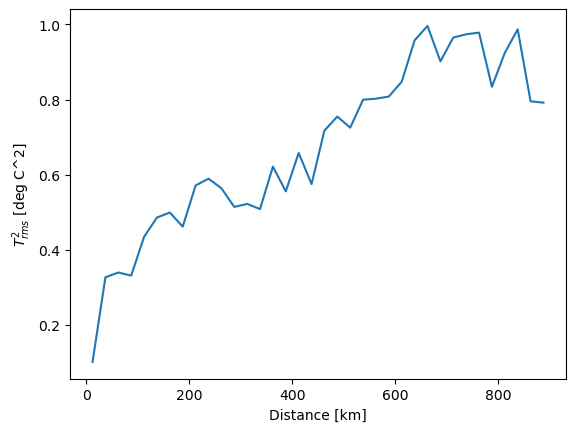

In [19]:
# Plot the binned structure function
# Variance /error increases with distance

fig, ax = plt.subplots()
plt.plot(ds,S_dx)
ax.set_xlabel('Distance [km]')
ax.set_ylabel('$T_{rms}^2$ [deg C^2]')

# Estimate noise and variance

Where noise (errsq), signal variance (var_signal), total variance (var_total) are in the equation for the structure function as

$$
2S = <T1^2> + <T2^2> -2<T1*T2> = 2<T^2> + 2<err^2> -2<T1*T2>
$$

for delt=0, this is the squared error.

for delt large, this is the total variance (signal variance plus the squared error).  

You can repeat the above calculations changing the mask_small_dt values.

In [20]:
errsqr = 1
var_total = 1.2
var_signal = var_total - errsqr

cov_ds = var_total - S_dx

## Fit a covariance function

$$
cov=var_{signal}*\exp(-ds^2/L_s^2-dt/L_t)
$$

Guess initial decorrelation length scale $L_s=300$ km, and decorrelation time scale of 10 days, $L_t=10$.

Text(0.5, 1.0, 'For Ls = 500km')

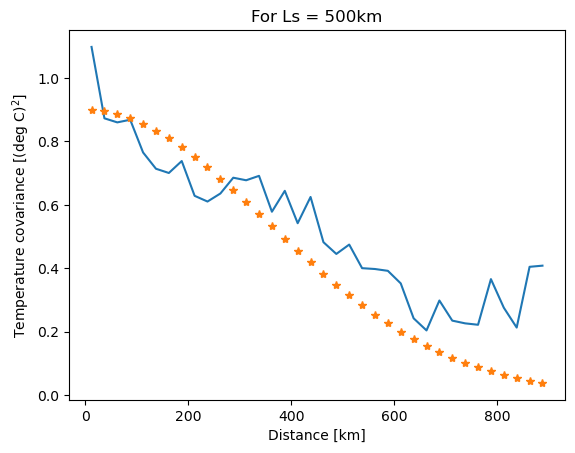

In [21]:
Ls = 500
Lt = 10

def my_covar_x(var_signal,ds,Ls):
    covx = var_signal*np.exp(-(ds/Ls)**2)
    
    return covx

var_sig2 = .9

covx = my_covar_x(var_sig2, ds, Ls)

fig,ax = plt.subplots()
plt.plot(ds,cov_ds)
plt.plot(ds,covx,'*')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Temperature covariance [(deg C)$^2$]')
ax.set_title('For Ls = ' + str(Ls) + 'km')

# Bin the structure function as a function of distance

49.96475363383023


Text(0, 0.5, '$T_{rms}^2$ [deg C^2]')

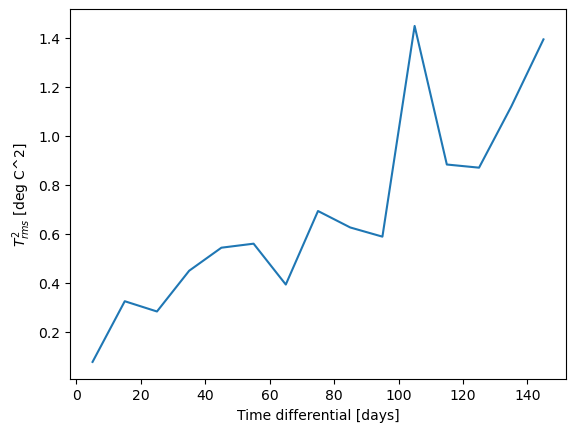

In [22]:
# Mask for nearby in time and in space
dt_bin = 10 # Temporal
maxt = 150

mask_small_dt = (data_covar.time_diff < maxt)
mask_small_ds = (data_covar.distance < ds_bin*2)
data_covar_near = data_covar.where(mask_small_dt & mask_small_ds, drop=True)

print(data_covar_near.distance.values.max())

# Subset the distances and the other values for small time differences
# Length of vector for distances
dt = np.arange(dt_bin/2, maxt, dt_bin)
S_dt = np.empty((0,0))
for jj in range(len(dt)):
    dsmall = dt[jj]-dt_bin/2
    dlarge = dt[jj]+dt_bin/2
    dt1 = data_covar_near.where((data_covar_near.time_diff >= dsmall) & (data_covar_near.time_diff < dlarge), drop=True)
    smean1 = np.nanmean(dt1.strfcn)
    S_dt = np.append(S_dt,smean1)

# Plot the binned structure function
# Variance /error increases with distance

fig, ax = plt.subplots()
plt.plot(dt,S_dt)
ax.set_xlabel('Time differential [days]')
ax.set_ylabel('$T_{rms}^2$ [deg C^2]')

Text(0.5, 1.0, 'For Lt = 80days')

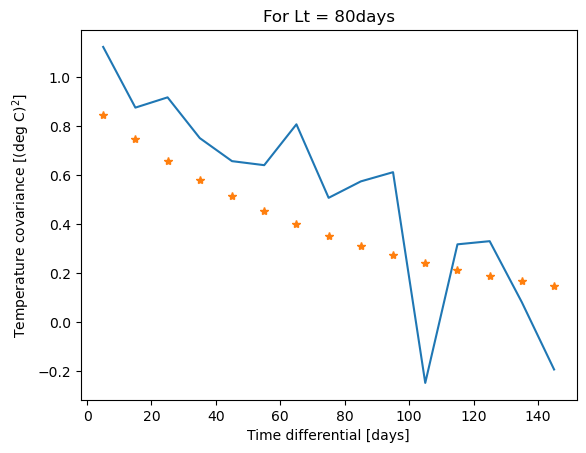

In [23]:
# Fit a covariance function
Ls = 500
Lt = 80
cov_dt = var_total - S_dt
def my_covar_t(var_signal,ds,Ls):
    covt = var_signal*np.exp(-dt/Lt)
    
    return covt

covt = my_covar_t(var_sig2, dt, Lt)

fig,ax = plt.subplots()
plt.plot(dt,cov_dt)
plt.plot(dt,covt,'*')
ax.set_xlabel('Time differential [days]')
ax.set_ylabel('Temperature covariance [(deg C)$^2$]')
ax.set_title('For Lt = ' + str(Lt) + 'days')

In [24]:
def my_covar_xt(var_signal,ds,Ls,dt,Lt):
    covxt = var_signal*np.exp(-(ds/Ls)**2-dt/Lt)

    return covxt



In [31]:
## run obj map routine 
# map 1 month at a time
# Define the maximum space/time intervals over which to grid
smax = .7*Ls
tmax = .7*Lt

# Define a map grid
latg = np.arange(minlat, maxlat, 1)
long = np.arange(minlon, maxlon, 1)

[xgrid, ygrid] = np.meshgrid(long,latg)

d1 = my_covar_xt(var_signal,smax,Ls,0,Lt)     # max space lag, no time lag
d2 = my_covar_xt(var_signal,0,Ls,tmax,Lt)     # max time lag, no space lag

data = argo_reg_good

epoch0 = mdates.date2num(np.datetime64('0000-01-01'))
epoch1 = mdates.date2num(np.datetime64('1970-01-01')+1)

vart = var_total
var = var_signal

ny, nx = xgrid.shape
nt = 4

mapT = np.empty((ny,nx,nt))
errT = np.empty((ny,nx,nt))

for mm in range(0,1):
    time1 = mdates.date2num(np.datetime64('2003-0' + str(mm+1) + '-15'))
    time2 = time1 + epoch1 - epoch0
    # call obj_map_2D
    

    tmap = time2
    longrid = xgrid
    latgrid = ygrid
    [ny, nx] = longrid.shape

    # Unpack the input data
    lon_data = data.lond
    lat_data = data.latd
    time_data = data.time # Note these are in Matlab datenum format (days since 0000-01-01)
    val_data = data.temp_anom

    err0 = np.sqrt(vart);

    # Initialise the mapped data & error
    mapdata = np.empty((ny, nx))
    err_rms = err0*np.ones(mapdata.shape)

    # Conversions for lat to kilometers
    yscl = 111
    cs = np.cos(np.mean(lat_data)*np.pi/180)

    # Cycle through positions in the grid
    for jj in range(0,ny):
        for ii in range(0,nx):
            print([ny,jj,ii])
            # Find distance (km) from data to the map grid point at
            # latgrid[jj,ii] and longrid[jj,ii]
            # Note: data_lon and data_lat are vectors of the same length
            dr = yscl * np.sqrt(cs * (lon_data - longrid[jj,ii])**2 + (lat_data - latgrid[jj,ii])**2)
            # Find the time difference between the time for the map (tmap) and of the data (time_data)
            dt = abs(time_data - tmap)
    
            # Boolean mask for distances < smax and time diff < tmax
            mask_near = (dr < smax) & (dt < tmax)
            mask_one = (dr < smax)
            mask_two = (dt < tmax)
            nptone = mask_one.sum().values
            npttwo = mask_two.sum().values
            # How many data points are near enough to be used?
            npt = mask_near.sum().values
            print([nptone,npttwo,npt])

            # If there are any original datapoints nearby in time/space, then continue
            if npt>0:
                # Subselect the input data for only those points near in time/space
                lat_near_ij = lat_data.where(mask_near, drop=True).values
                lon_near_ij = lon_data.where(mask_near, drop=True).values
                time_near_ij = time_data.where(mask_near, drop=True).values
                val_near_ij = val_data.where(mask_near, drop=True).values
                dr_near_ij = dr.where(mask_near, drop=True).values
                dt_near_ij = dt.where(mask_near, drop=True).values

                # Compute data-grid covariance vector
                zz = my_covar_xt(var,dr_near_ij,Ls,dt_near_ij,Lt)
                
                # Compute data-data covariance matrix
                # Initialise an empty matrix, sized npt x npt square matrix
                C = np.empty((npt,npt))

                for iii in range(0,npt):
                    lat_data1 = lat_near_ij[iii]
                    lon_data1 = lon_near_ij[iii]
                    time_data1 = time_near_ij[iii]
                    
                    for jjj in range(0,npt):
                        lat_data2 = lat_near_ij[jjj]
                        lon_data2 = lon_near_ij[jjj]
                        time_data2 = time_near_ij[jjj]

                        # Compute distance between pairs of data points
                        dr_data = yscl*np.sqrt(cs * (lon_data2 - lon_data1)**2+(lat_data2 - lat_data1)**2)

                        # Compute delta time between the data points
                        dt_data = abs(time_data2 - time_data1)

                        # Covariance matrix
                        C[iii,jjj] = my_covar_xt(var,dr_data,Ls,dt_data,Lt)
    
                # Compute map value and error estimate
                alpha = np.linalg.solve(C,zz)
    
                # Map the data values into the map locations
                dhat = val_near_ij.conj().transpose() @ alpha
                # Estimate the error
                ersqs = vart - zz.conj().transpose() @ alpha
    
                # Value & error at nearest point (max covariance)
                zz0 = zz.max()
                kk = zz.argmax()
                err1 = vart - zz0**2/var
    
                # Check for instability:
                # 1) estimated error > error for single nearest point, or
                # 2) squared error < 0
                # For one datum: alpha = zz0/var
                if (ersqs > err1) | (ersqs < 0):
                    print(ii)
                    print(jj)
                    dij = dij(kk) # at max zz
                    ersqs = err1
                    alpha = zz0/var
                    dhat = val_near_ij.conj().transpose() @ alpha
        
                # Map values
                mapdata[jj,ii] = dhat
                err_rms[jj,ii] = np.sqrt(ersqs)
            else:
                mapdata[jj,ii] = 0
                err_rms[jj,ii] = 0

    
    mapT[:,:,mm] = mapdata;
    errT[:,:,mm] = err_rms;


[10, 0, 0]
[array(8), array(107), array(3)]
[10, 0, 1]
[array(14), array(107), array(6)]
[10, 0, 2]
[array(19), array(107), array(9)]
[10, 0, 3]
[array(31), array(107), array(13)]
[10, 0, 4]
[array(35), array(107), array(11)]
[10, 0, 5]
[array(36), array(107), array(11)]
[10, 0, 6]
[array(27), array(107), array(6)]
[10, 0, 7]
[array(21), array(107), array(5)]
[10, 0, 8]
[array(23), array(107), array(5)]
[10, 0, 9]
[array(14), array(107), array(3)]
[10, 0, 10]
[array(9), array(107), array(0)]
[10, 0, 11]
[array(6), array(107), array(0)]
[10, 0, 12]
[array(3), array(107), array(0)]
[10, 0, 13]
[array(7), array(107), array(2)]
[10, 0, 14]
[array(10), array(107), array(3)]
[10, 0, 15]
[array(11), array(107), array(3)]
[10, 0, 16]
[array(11), array(107), array(3)]
[10, 0, 17]
[array(10), array(107), array(3)]
[10, 0, 18]
[array(10), array(107), array(3)]
[10, 0, 19]
[array(9), array(107), array(3)]
[10, 1, 0]
[array(15), array(107), array(8)]
[10, 1, 1]
[array(24), array(107), array(12)]
[1

(array([799.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.07570996e+000,  9.48462959e+280,  1.89692592e+281,
         2.84538888e+281,  3.79385184e+281,  4.74231480e+281,
         5.69077776e+281,  6.63924072e+281,  7.58770368e+281,
         8.53616663e+281,  9.48462959e+281]),
 <BarContainer object of 10 artists>)

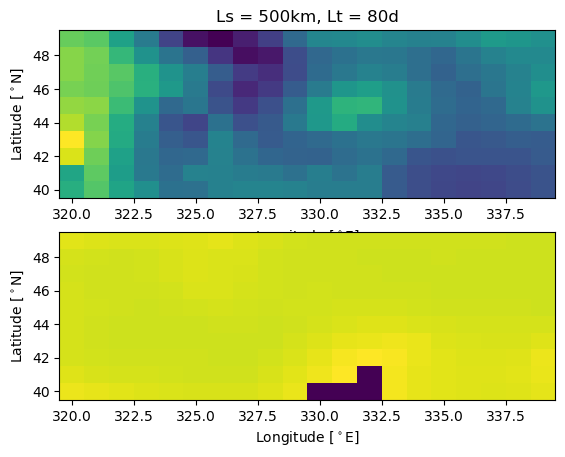

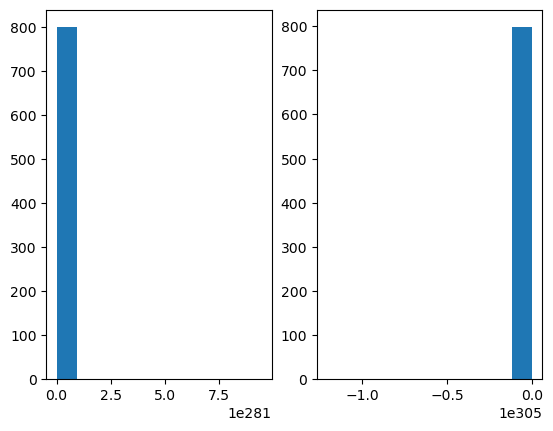

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].pcolormesh(xgrid,ygrid,mapT[:,:,0])
ax[0].set_xlabel('Longitude [$^\circ$E]')
ax[0].set_ylabel('Latitude [$^\circ$N]')
ax[0].set_title('Ls = ' + str(Ls) + 'km, Lt = ' + str(Lt) + 'd')
ax[1].pcolormesh(xgrid,ygrid,errT[:,:,0])
ax[1].set_xlabel('Longitude [$^\circ$E]')
ax[1].set_ylabel('Latitude [$^\circ$N]')
fig, ax = plt.subplots(1,2)
ax[1].hist(errT.flatten())
ax[0].hist(mapT.flatten())
